In [1]:
%load_ext autoreload

%autoreload 2

# Adversarial Examples by Fast Gradient Sign

In [2]:
from IPython.display import clear_output, display
import numpy as np
import matplotlib.pyplot as plt

import torch as t
from torch.nn import Sequential, Linear, ReLU, LeakyReLU
import torchvision

import os

import utils as u

In [3]:
%matplotlib inline

In [4]:
if t.cuda.is_available():
    if t.cuda.device_count()>1:
        device = t.device('cuda:1')
    else:
        device = t.device('cuda')   
else:
    device = t.device('cpu')

In [5]:
#device=t.device('cpu')

## MNIST 

In [6]:
from keras.datasets import mnist

Using TensorFlow backend.


In [7]:
(x_train,y_train), (x_test, y_test) = mnist.load_data()

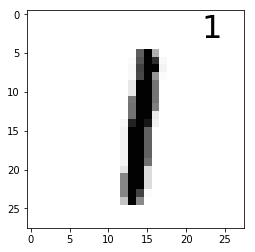

In [8]:
index=40
plt.imshow(x_train[index], cmap='Greys')
plt.text(22,3,'%d' % (y_train[index],), fontsize=32);

In [9]:
train_dataset = u.make_dataset(x_train, y_train, device)
test_dataset  = u.make_dataset(x_test, y_test, device) 

In [10]:
train_loader = t.utils.data.DataLoader(train_dataset, batch_size=128)

In [11]:
if os.path.isfile('mnist_home_model.pt'):
    model = t.load('mnist_home_model.pt')
    pretrained = True
else:        
    model = utils.make_model(32, drop=0.0)
    model.apply(u.init_layer)
    pretrained = False
    

In [12]:
model.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): Dropout(p=0.0)
  (2): ReLU()
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): Dropout(p=0.0)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): Dropout(p=0.0)
  (8): ReLU()
  (9): Linear(in_features=32, out_features=10, bias=True)
)

In [13]:
u.accuracy(model, test_dataset[:][0], test_dataset[:][1])

0.9699

In [14]:
ce = t.nn.CrossEntropyLoss()

In [15]:
optimizer = t.optim.Adam(model.parameters(), lr=0.0002)

In [16]:
%%time
if not pretrained:
    err_train=[]
    err_valid=[]
    for epoch in range(50):    
        for datum in train_loader:
            optimizer.zero_grad()
            (features,target) = datum
            pred = model(features)
            loss = ce(pred, target)
            loss.backward()
            optimizer.step()

        with t.no_grad():
            vpred  = model(test_dataset[:][0])
            vloss  = ce(vpred,test_dataset[:][1])
            err_valid.append(vloss)
            pred  = model(train_dataset[:][0])
            loss  = ce(pred,train_dataset[:][1])
            err_train.append(loss)
        clear_output()
        print("epoch %d %f %f %f %f" % 
              (epoch, loss, vloss, 
                accuracy(model, train_dataset[:][0],  train_dataset[:][1]),
               accuracy(model, test_dataset[:][0],  test_dataset[:][1])
                                       )   )

    plt.plot(err_train,c='b')
    plt.plot(err_valid,c='g')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 4.77 µs


In [17]:
vpred  = model(test_dataset[:][0])
vloss  = ce(vpred,test_dataset[:][1])
pred  = model(train_dataset[:][0])
loss  = ce(pred,train_dataset[:][1])
print(loss.item(), vloss.item())

0.050521522760391235 0.09384958446025848


In [18]:
print(u.accuracy(model, test_dataset[:][0],  test_dataset[:][1]) )
print(u.accuracy(model, train_dataset[:][0], train_dataset[:][1]) )

0.9699
0.9862


In [19]:
if not os.path.isfile('mnist_home_model.pt'):
    t.save(model,"mnist_home_model.pt")

In [20]:
u.model_detach(model)

In [21]:
idx = 455
X = train_dataset[idx:idx+1][0].clone()
L = train_dataset[idx:idx+1][1].clone()

1


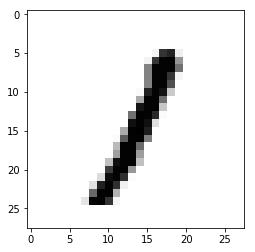

In [22]:
plt.imshow(X.data.cpu().numpy().reshape(28,28), cmap='Greys')
print(L.item())

In [23]:
pred = model(X)
ce(pred,L)

tensor(0.0007)

In [24]:
u.prediction(model, X)

(1, 0.999308705329895)

## Noise

In [25]:
eta = t.empty_like(X).normal_(0,0.1)

In [26]:
X_noisy = t.clamp(X+eta,0,1)

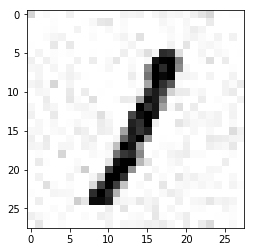

In [27]:
plt.imshow(X_noisy.detach().cpu().numpy().reshape(28,28), cmap='Greys')

In [28]:
u.prediction(model, X_noisy)

(1, 0.9148237109184265)

In [29]:
%time
test_noisy = test_dataset[:][0]+t.empty_like(test_dataset[:][0]).normal_(0.0, 0.1)
test_noisy = test_noisy.to(device);

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs


In [30]:
u.accuracy(model, test_noisy, test_dataset[:][1])

0.9594

## Linearity

> "Explaining and Harnessing Adversarial Examples", Ian J. Goodfellow, Jonathon Shlens, Christian Szegedy [arXiv:1412.6572](https://arxiv.org/abs/1412.6572)

$$\newcommand{\b}[1]{\mathbf{#1}}$$
$$  J(\b{x}) = \mathbf{w}\cdot \mathbf{x} $$

$$J(\b{x}+\b\delta)= \mathbf{w}\cdot \mathbf{x} + \mathbf{w}\cdot \mathbf{\delta}$$

In [31]:
w = np.random.uniform(-0.25, 0.25,1000)

In [32]:
x = np.random.uniform(0, 1,1000)

In [33]:
w @ x

3.2665261930889535

In [34]:
epsilon = 0.2

In [35]:
noise = np.random.normal(0,epsilon, 1000)

In [36]:
w @(x+noise) - w @x

0.90136326133974

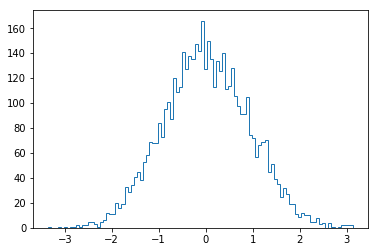

In [37]:
J_sample =  np.random.normal(0,epsilon, (5000,1000))@w
plt.hist(J_sample, bins=100, histtype='step');

$$\newcommand{\sign}{\operatorname{sign}}$$
$$\eta = \epsilon\sign \b{w}$$

$$\b{w}\cdot\b{\eta} = \epsilon\sum_{i=1}^N |w_i|  \sim \epsilon N E[|w|]$$

In [38]:
adv_noise = epsilon*np.sign(w)

In [39]:
w @(x+adv_noise) - w @x

25.24400274166671

### But Neural Networks are highly non-linear? Right?

### Wrong! Neural Networks are designed to be quite linear. 

### Fast Gradient Sign

$$J(\b{X}+\b{\delta}) \approx J(\b{X})+\nabla_{\b{X}} J(\b{X})\cdot\b{\delta}$$

$$\newcommand{\grad}{\operatorname{grad}}$$
$$\nabla_{\b{X}} J(\b{X})=\grad_{\b{X}} J(\b{X})
\equiv\frac{\partial J(\b{X})}{\partial {X_i}},
\quad i=1,\ldots,N$$

$$\delta = \epsilon \sign \nabla_{\b{X}} J(\b{X})$$

In [40]:
idx = 899
X = train_dataset[idx:idx+1][0].clone()
L = train_dataset[idx:idx+1][1]
print(L.item())

5


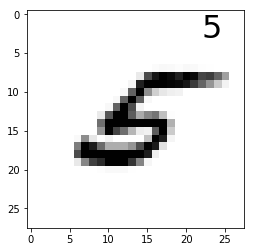

In [41]:
plt.imshow(X.data.cpu().numpy().reshape(28,28), cmap='Greys')
plt.text(22,3,'%d' % (L,), fontsize=32);

In [42]:
def FGS(model,orig, label, eps):
    orig.requires_grad_(True);
    if orig.grad is not None:
        orig.grad.zero_()
    loss = ce(model(orig.reshape(1,-1)), label.view(1))
    loss.backward() 
    XG = orig.grad
    eta = eps*XG.sign()
    orig.requires_grad_(False)
    return (orig+eta)

In [43]:
%%time
AdvX = FGS(model, X,L, 0.05)

CPU times: user 10.8 ms, sys: 1.02 ms, total: 11.8 ms
Wall time: 2.97 ms


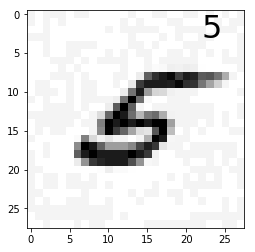

In [44]:
plt.imshow(AdvX.data.cpu().numpy().reshape(28,28), cmap='Greys')
plt.text(22,3,'%d' % (L,), fontsize=32);

In [45]:
u.prediction(model, AdvX)

(4, 0.9998747110366821)

In [46]:
# t.save(X, 'real_5.pt')
# t.save(AdvX,'fake_4.pt')

In [47]:
%time
test_adv = t.stack([FGS(model,x,l,0.05) for x,l in zip(test_dataset[:][0], test_dataset[:][1])],dim=0)
test_adv=test_adv.to(device);

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [48]:
u.accuracy(model, test_adv, test_dataset[:][1])

0.0689

(2, 0.4237806499004364)

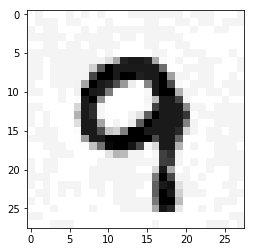

In [49]:
plt.imshow(test_adv[99].data.cpu().numpy().reshape(28,28), cmap='Greys')
u.prediction(model,test_adv[99:100])

In [50]:
eps =  np.linspace(-0.1,0.1, 100)

X.requires_grad=True
X.grad.data.zero_()
out = model(X)
loss = ce(out,L)
loss.backward()
grad_X = X.grad.data.view(-1)


In [51]:
ls = []
eta = grad_X.sign()
for e in eps:
    out = model(X.detach()+e*eta)
    loss = ce(out,L)
    ls.append(loss.item())

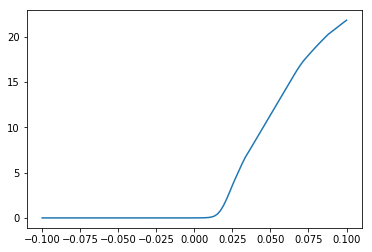

In [52]:
plt.plot(eps, ls)

In [53]:
outs =[]
eta = grad_X.sign()
for e in eps:
    out = model(X.detach()+e*eta)
    outs.append(out)

outs = t.stack(outs,0)
outs.squeeze_();

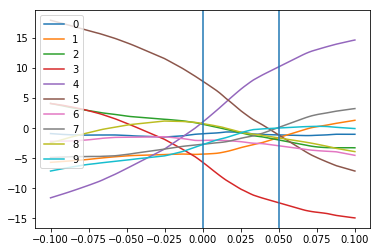

In [54]:
for i in range(10):
    plt.plot(eps,outs.cpu().numpy()[:,i], label='%d' % (i,))
plt.axvline(0)   
plt.axvline(0.05)
plt.legend()    

### But those examples are targeted for specific network?

### Not really ...

## Generalisation

In [55]:
if os.path.isfile('another_mnist.pt'):
    another_model = t.load('another_mnist.pt')
    another_pretrained = True
else:
    another_model = u.make_model(64,0.2)

    another_model.apply(u.init_layer)
    another_pretrained = False

In [56]:
another_optimizer=t.optim.Adam(another_model.parameters(), lr=0.0002, betas=[0.5, 0.999])

epoch 19 0.080017 0.129686 0.963700


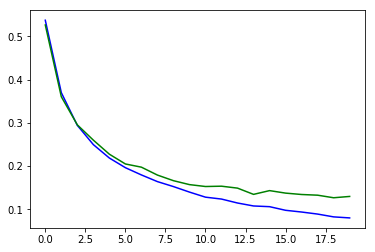

In [57]:
another_model.to(device)
if not another_pretrained:
    err_train=[]
    err_valid=[]
    for epoch in range(20):    
        for datum in train_loader:
            another_optimizer.zero_grad()
            (features,target) = datum
            pred = another_model(features)
            loss = ce(pred, target)
            loss.backward()
            another_optimizer.step()

        with t.no_grad():
            vpred  = another_model(test_dataset[:][0])
            vloss  = ce(vpred,test_dataset[:][1])
            err_valid.append(vloss)
            pred  = another_model(train_dataset[:][0])
            loss  = ce(pred,train_dataset[:][1])
            err_train.append(loss)
        clear_output()
        print("epoch %d %f %f %f" % (epoch, loss, vloss,u.accuracy(another_model, test_dataset[:][0],  test_dataset[:][1])))   

    plt.plot(err_train,c='b')
    plt.plot(err_valid,c='g')

In [58]:
if not os.path.isfile('another_mnist.pt'):
    t.save(another_model, 'another_mnist.pt')

In [59]:
u.accuracy(another_model, test_dataset[:][0], test_dataset[:][1])

0.964

In [60]:
u.accuracy(another_model, test_adv, test_dataset[:][1])

0.665

## Adversarial trening

In [61]:
%time
train_adv = t.stack([FGS(model,x,l,0.05) for x,l in zip(train_dataset[:][0], 
                                                                train_dataset[:][1])],dim=0)
train_adv = train_adv.to(device);

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs


In [62]:
adv_dataset = t.utils.data.TensorDataset(train_adv,train_dataset[:][1])

In [63]:
combined_dataset = t.utils.data.ConcatDataset((train_dataset, adv_dataset))

In [64]:
combined_loader = t.utils.data.DataLoader(combined_dataset, batch_size=128, shuffle=True)

In [65]:
u.model_atach(model)

In [66]:
err_train=[]
err_valid=[]
for epoch in range(1,21):    
    for datum in combined_loader:
        optimizer.zero_grad()
        (features,target) = datum
        pred = model(features)
        loss = ce(pred, target)
        loss.backward()
        optimizer.step()

    with t.no_grad():
        vpred  = model(test_dataset[:][0])
        vloss  = ce(vpred,test_dataset[:][1])
        err_valid.append(vloss)
        pred  = model(train_dataset[:][0])
        loss  = ce(pred,train_dataset[:][1])
        err_train.append(loss)
    clear_output()
    print("epoch %d %f %f %f" % (epoch, loss, vloss,u.accuracy(another_model, test_dataset[:][0],  test_dataset[:][1])))   

epoch 20 0.011771 0.092626 0.964800


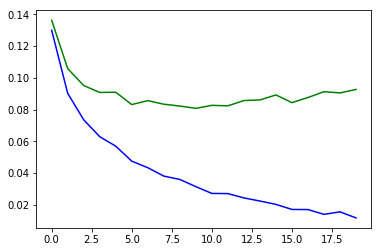

In [67]:
plt.plot(err_train,c='b')
plt.plot(err_valid,c='g')

In [68]:
u.accuracy(model, test_dataset[:][0], test_dataset[:][1])

0.9744

In [69]:
u.accuracy(model, test_adv, test_dataset[:][1])

0.9972

In [70]:
%time
test_adv = t.stack([FGS(model,x,l,0.05) for x,l in zip(test_dataset[:][0], test_dataset[:][1])],dim=0)
test_adv  =test_adv.to(device);

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs


In [71]:
u.accuracy(model, test_adv, test_dataset[:][1])

0.0657

## Targeted Fast Gradient Sign (T-FGS)

> "Adversarial examples in the physical world", Alexey Kurakin, Ian Goodfellow, Samy Bengio [arXiv:1607.02533](https://arxiv.org/abs/1607.02533)

In [72]:
model = t.load('mnist_home_model.pt').to(device)
u.model_detach(model)

In [73]:
idx = 89
Y = train_dataset[idx:idx+1][0].clone()
L = train_dataset[idx:idx+1][1]
print(L.item())

4


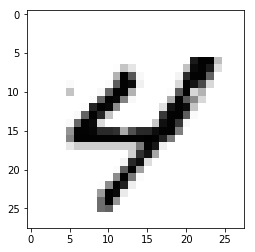

In [74]:
plt.imshow(Y.cpu().numpy().reshape(28,28), cmap='Greys')

In [75]:
u.prediction(model, Y)

(4, 0.9996703863143921)

In [76]:
T = t.LongTensor([3]).to(device)

$$ J(X, T) $$

$$ X-\epsilon \nabla_X J(X, T) $$

In [77]:
def T_FGS(model,orig, label, target, eps):
    orig.requires_grad_(True);
    if orig.grad is not None:
        orig.grad.zero_()
    loss = ce(model(orig.reshape(1,-1)), target.view(1))
    loss.backward() 
    XG = orig.grad
    eta = eps*XG.sign()
    orig.requires_grad_(False)
    return t.clamp(orig-eta, 0,1)

In [78]:
Y_adv = T_FGS(model, Y,L,T,0.15)

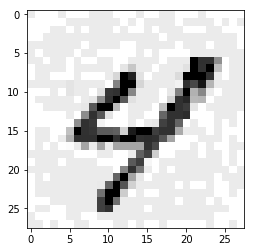

In [79]:
plt.imshow(Y_adv.cpu().numpy().reshape(28,28), cmap='Greys')

In [80]:
u.prediction(model,Y_adv)

(3, 0.9978318810462952)

## Targeted Iterative Fast Gradient Sign (T-FGS)

$$ X_0=X$$
$$ X_{i+1}-\epsilon \nabla_X J(X_i, T) $$

In [81]:
def T_FGS_I(model,orig, label, target, eps, n_iter=3):
    i_eps = eps/n_iter
    adv = orig
    for i in range(n_iter):
        adv=T_FGS(model, adv, label, target, i_eps)
    return adv    
        
    

In [82]:
Y_adv = T_FGS_I(model, Y,L,T,0.1)

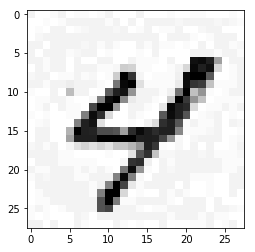

In [83]:
plt.imshow(Y_adv.cpu().numpy().reshape(28,28), cmap='Greys')

In [84]:
u.prediction(model,Y_adv)

(3, 0.9858537912368774)